## Buisness understanding..
Data from Walmart stores accross the US is given, and it is up to us to forecast their weekly sales. The data is already 
split into a training and a test set, and we want to fit a model to the training data that is able to forecast those weeks 
sales as accurately as possible. In fact, our metric of interest will be the Mean Absolute Error.

#  Load and explore the data..

In [1]:
# import libraries
import pandas as pd
import numpy as np
import os as os
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler 
import matplotlib.pyplot as plt

In [2]:
os.chdir("D:\DataScience\TimeSeries\Python\Walmart")
TrainDs=pd.read_csv("D:\\DataScience\\TimeSeries\\Python\\Walmart\\train.csv")
TestDs=pd.read_csv("D:\\DataScience\\TimeSeries\\Python\\Walmart\\test.csv")

In [3]:
# View the data
TrainDs.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,26,92,2011-08-26,87235.57,False,61.10,3.796,NaN,NaN,NaN,NaN,NaN,136.213613,7.767,A,152513
1,34,22,2011-03-25,5945.97,False,53.11,3.480,NaN,NaN,NaN,NaN,NaN,128.616064,10.398,A,158114
2,21,28,2010-12-03,1219.89,False,50.43,2.708,NaN,NaN,NaN,NaN,NaN,211.265543,8.163,B,140167
3,8,9,2010-09-17,11972.71,False,75.32,2.582,NaN,NaN,NaN,NaN,NaN,214.878556,6.315,A,155078
4,19,55,2012-05-18,8271.82,False,58.81,4.029,12613.98,NaN,11.5,1705.28,3600.79,138.106581,8.150,A,203819


In [4]:
TrainDs.shape    ## 282451 totoal rows..

(282451, 16)

In [5]:
TestDs.head()

,Store,Dept,Date,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,28,40,2012-01-06,False,50.43,3.599,5155.86,19549.51,218.29,636.73,5218.50,130.157516,12.187,A,206302
1,18,93,2012-03-09,False,38.10,3.876,7410.18,368.19,25.46,1852.39,2332.07,137.506690,8.075,B,120653
2,38,4,2011-05-27,False,76.67,4.087,NaN,NaN,NaN,NaN,NaN,129.062355,13.736,C,39690
3,29,33,2010-03-12,False,43.43,2.805,NaN,NaN,NaN,NaN,NaN,131.784000,10.064,B,93638
4,13,52,2010-10-29,False,45.12,2.841,NaN,NaN,NaN,NaN,NaN,126.436419,7.795,A,219622


In [6]:
TrainDs.Date = pd.to_datetime(TrainDs['Date']) 
TrainDs.set_index('Date',inplace=True)
TestDs.Date = pd.to_datetime(TestDs['Date']) 
TestDs.set_index('Date',inplace=True)

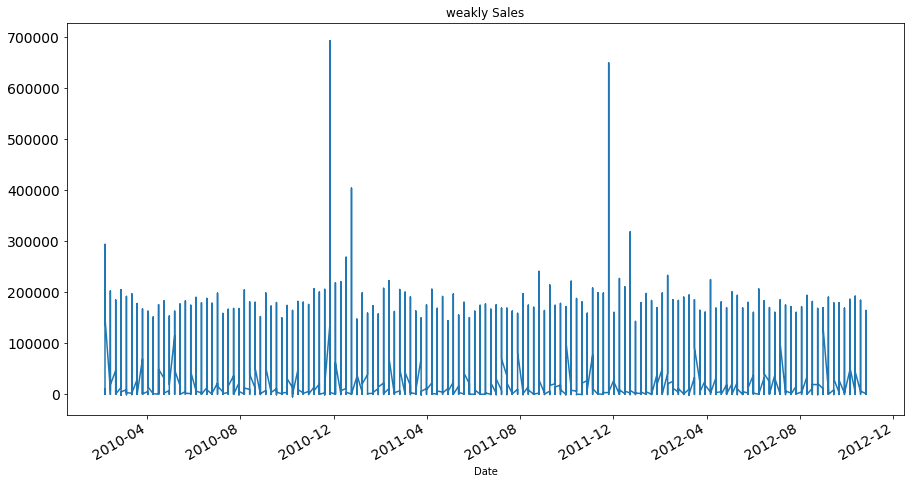

In [7]:
## lets visualize the weekly sales data over time period.
TrainDs.Weekly_Sales.plot(figsize=(15,8), title= 'weakly Sales', fontsize=14)
## we obsereve the sales are quiet high in december. for rest of the months the sale peaks are quiet consistent.

In [8]:
TrainDs.describe()
## The sale is not evenly distributed .. the sales dustribution is even form 0-75%  and the mean is much lower than
#max of the sale reached which says more sales are b/w 25-75 quantile..## outliers are present..

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,282451.000000,282451.000000,282451.000000,282451.000000,282451.000000,100520.000000,74232.000000,91521.000000,90031.000000,101029.000000,282451.000000,282451.000000,282451.000000
mean,22.193166,44.286138,15983.429692,60.113640,3.360300,7246.077559,3318.408122,1417.397841,3379.591745,4639.476021,171.207802,7.968098,136730.073220
std,12.782138,30.503641,22661.092494,18.446485,0.458602,8254.606267,9485.575898,9547.858949,6269.428446,6060.459590,39.160808,1.868070,61002.319363
min,1.000000,1.000000,-4988.940000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2079.330000,46.780000,2.932000,2241.190000,40.960000,5.060000,508.100000,1877.810000,132.022667,6.891000,93638.000000
50%,22.000000,38.000000,7616.550000,62.150000,3.452000,5363.520000,191.820000,24.340000,1482.030000,3364.410000,182.350989,7.866000,140167.000000
75%,33.000000,74.000000,20245.745000,74.290000,3.737000,9235.590000,1919.790000,103.130000,3607.570000,5563.800000,212.464799,8.572000,202505.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000


In [9]:
#Lets merge the whole data..
t_len = len(TrainDs) # Get number of training examples
df = pd.concat([TrainDs,TestDs],axis=0) # Join train and test
df.tail() #

C:\Users\sbha69\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


,CPI,Dept,Fuel_Price,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Size,Store,Temperature,Type,Unemployment,Weekly_Sales
Date,,,,,,,,,,,,,,,
2011-11-18,129.826833,91,3.669,False,86.59,6.00,NaN,NaN,3220.86,39690,33,63.35,A,8.010,NaN
2012-03-02,130.645793,85,3.242,False,25204.67,2436.75,167.88,16066.76,7289.69,219622,13,32.36,A,6.104,NaN
2011-01-28,211.855267,91,3.010,False,NaN,NaN,NaN,NaN,NaN,42988,30,44.04,C,8.028,NaN
2012-06-08,197.655186,32,3.741,False,8483.84,361.80,77.99,1640.00,6841.59,203007,32,71.14,A,8.090,NaN
2012-04-13,141.843393,33,4.187,False,5139.48,4770.63,53.84,1532.47,4176.90,204184,27,52.22,A,8.253,NaN


In [10]:
## Lets check for autocorelation in data..
corr=df.corr()

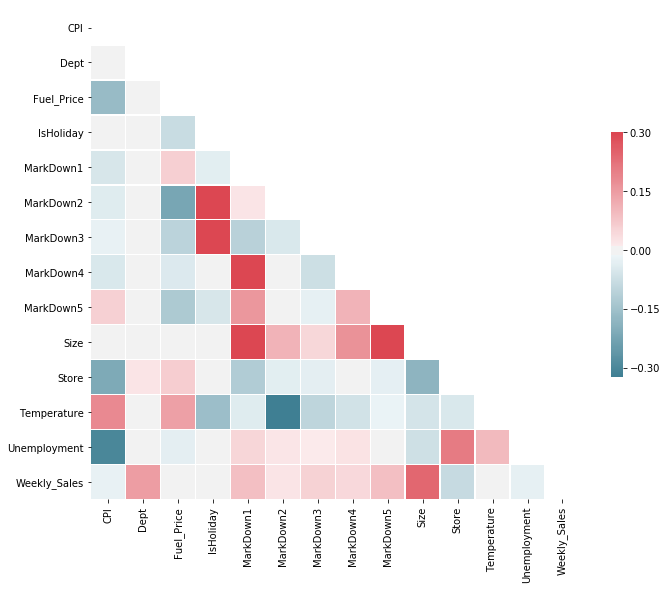

In [11]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

 #Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [12]:
#Discounts are correlated and higher unemployment means lower Consumer Price Index. More interestingly, it appears
#that higher department numbers have higher sales. Maybe because they are newer? Also, larger stores generate more sales,
#discounts generally generate higher sales values and larger unemployment result in a bit fewer sales. Unfortunately,
#there appears to be little relationship between holidays, temperatures or fuelprices with our weekly sales.

In [13]:
## Lets see these plots closely. The effect of various factors on Weakly_sales.

C:\Users\sbha69\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


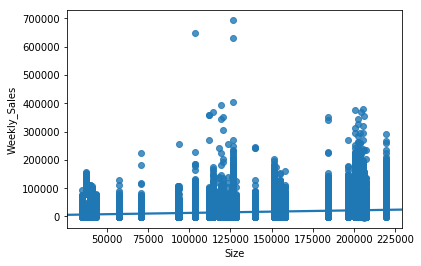

In [14]:
sns.regplot(x=df["Size"], y=df["Weekly_Sales"])
##as the size increases the weakly_sales has an increasing trend with some sudden peaks around mid of time..

C:\Users\sbha69\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


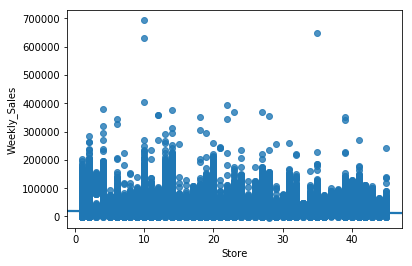

In [15]:
sns.regplot(x=df["Store"], y=df["Weekly_Sales"])
# the weakly sales are quiet consistent with the stores though some sudden rise(peaks) is present in data.

C:\Users\sbha69\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


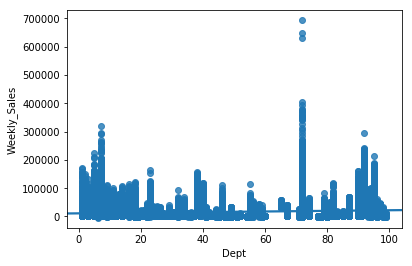

In [16]:
sns.regplot(x=df["Dept"], y=df["Weekly_Sales"])
# Overall there is an increse in weakly sales as the Dept increses.

C:\Users\sbha69\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


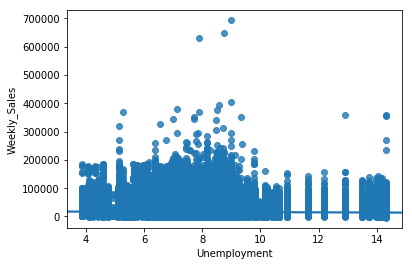

In [17]:
sns.regplot(x=df["Unemployment"], y=df["Weekly_Sales"])
# The weakly sales decreases with the increase in unemployment.though there are some fluctuations observed.

In [18]:
df.loc[df['Weekly_Sales'] >300000]

,CPI,Dept,Fuel_Price,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Size,Store,Temperature,Type,Unemployment,Weekly_Sales
Date,,,,,,,,,,,,,,,
2010-11-26,132.836933,72,3.070,True,NaN,NaN,NaN,NaN,NaN,114533,23,34.95,B,5.287,369830.98
2010-11-26,210.515277,72,2.735,True,NaN,NaN,NaN,NaN,NaN,184109,39,67.75,A,8.476,339700.62
2010-11-26,132.836933,72,3.070,True,NaN,NaN,NaN,NaN,NaN,120653,18,40.81,B,9.331,353008.64
2011-11-25,129.836400,72,3.760,True,174.72,329.00,141630.61,79.00,1009.98,126512,10,60.68,B,7.874,630999.19
2010-11-26,126.669267,72,2.752,True,NaN,NaN,NaN,NaN,NaN,205863,4,48.08,A,7.127,381072.11
2010-12-24,126.983581,72,3.236,False,NaN,NaN,NaN,NaN,NaN,126512,10,57.06,B,9.003,404245.03
2011-11-25,140.421786,72,3.689,True,164.01,27.47,73934.06,24.22,540.56,204184,27,47.88,A,7.906,368484.19
2010-11-26,126.669267,72,3.162,True,NaN,NaN,NaN,NaN,NaN,112238,12,47.66,B,14.313,359995.60
2011-11-25,140.421786,72,3.536,True,1649.31,NaN,70087.94,7.50,5266.90,119557,22,46.28,B,7.706,345532.23


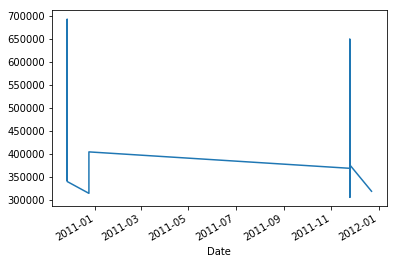

In [19]:
df.loc[df['Weekly_Sales'] >300000]["Weekly_Sales"].plot()

In [20]:
df.head()

,CPI,Dept,Fuel_Price,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Size,Store,Temperature,Type,Unemployment,Weekly_Sales
Date,,,,,,,,,,,,,,,
2011-08-26,136.213613,92,3.796,False,NaN,NaN,NaN,NaN,NaN,152513,26,61.10,A,7.767,87235.57
2011-03-25,128.616064,22,3.480,False,NaN,NaN,NaN,NaN,NaN,158114,34,53.11,A,10.398,5945.97
2010-12-03,211.265543,28,2.708,False,NaN,NaN,NaN,NaN,NaN,140167,21,50.43,B,8.163,1219.89
2010-09-17,214.878556,9,2.582,False,NaN,NaN,NaN,NaN,NaN,155078,8,75.32,A,6.315,11972.71
2012-05-18,138.106581,55,4.029,False,12613.98,NaN,11.5,1705.28,3600.79,203819,19,58.81,A,8.150,8271.82


In [21]:

## High Rise in sales While 25-26(holoday) Nov and 23-24 Dec(christmas Period)

In [22]:
##Perform EDA on Data..
df.apply(lambda x: sum(x.isnull().values),axis=0)
## there are misisng values in target -> weakly sales.. 49% of weakly sales data are misisng.. for markdowns misisng value is no mark
# down..

CPI                  0
Dept                 0
Fuel_Price           0
IsHoliday            0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
Size                 0
Store                0
Temperature          0
Type                 0
Unemployment         0
Weekly_Sales    139119
dtype: int64

In [23]:
df = df.assign(md1_present = df.MarkDown1.notnull())
df = df.assign(md2_present = df.MarkDown2.notnull())
df = df.assign(md3_present = df.MarkDown3.notnull())
df = df.assign(md4_present = df.MarkDown4.notnull())
df = df.assign(md5_present = df.MarkDown5.notnull())

In [24]:
## outlier treatement..
low = .05
high = .95
quant_df = df.quantile([low, high])
print(quant_df)
df=df[(df["Weekly_Sales"]<50570.2915)&(df["Weekly_Sales"]>0.00)]

             CPI  Dept  Fuel_Price  IsHoliday  MarkDown1  MarkDown2  \
0.05  126.496258   4.0       2.653        0.0     149.19       1.95   
0.95  221.941558  95.0       4.029        1.0   21801.35   16497.47   

      MarkDown3  MarkDown4  MarkDown5      Size  Store  Temperature  \
0.05       0.65      28.76     715.52   39690.0    3.0        27.31   
0.95    1059.90   12645.96   11269.24  206302.0   43.0        87.27   

      Unemployment  Weekly_Sales  md1_present  md2_present  md3_present  \
0.05         5.326        60.000          0.0          0.0          0.0   
0.95        12.187     61133.745          1.0          1.0          1.0   

      md4_present  md5_present  
0.05          0.0          0.0  
0.95          1.0          1.0  


In [25]:
TrainDs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 282451 entries, 2011-08-26 to 2011-10-14
Data columns (total 15 columns):
Store           282451 non-null int64
Dept            282451 non-null int64
Weekly_Sales    282451 non-null float64
IsHoliday       282451 non-null bool
Temperature     282451 non-null float64
Fuel_Price      282451 non-null float64
MarkDown1       100520 non-null float64
MarkDown2       74232 non-null float64
MarkDown3       91521 non-null float64
MarkDown4       90031 non-null float64
MarkDown5       101029 non-null float64
CPI             282451 non-null float64
Unemployment    282451 non-null float64
Type            282451 non-null object
Size            282451 non-null int64
dtypes: bool(1), float64(10), int64(3), object(1)
memory usage: 32.6+ MB


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 260472 entries, 2011-03-25 to 2011-10-14
Data columns (total 20 columns):
CPI             260472 non-null float64
Dept            260472 non-null int64
Fuel_Price      260472 non-null float64
IsHoliday       260472 non-null bool
MarkDown1       92329 non-null float64
MarkDown2       67800 non-null float64
MarkDown3       83709 non-null float64
MarkDown4       82259 non-null float64
MarkDown5       92822 non-null float64
Size            260472 non-null int64
Store           260472 non-null int64
Temperature     260472 non-null float64
Type            260472 non-null object
Unemployment    260472 non-null float64
Weekly_Sales    260472 non-null float64
md1_present     260472 non-null bool
md2_present     260472 non-null bool
md3_present     260472 non-null bool
md4_present     260472 non-null bool
md5_present     260472 non-null bool
dtypes: bool(6), float64(10), int64(3), object(1)
memory usage: 31.3+ MB


In [27]:
df.fillna(0,inplace=True)

In [28]:
df.apply(lambda x: sum(x.isnull().values),axis=0)

CPI             0
Dept            0
Fuel_Price      0
IsHoliday       0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
Size            0
Store           0
Temperature     0
Type            0
Unemployment    0
Weekly_Sales    0
md1_present     0
md2_present     0
md3_present     0
md4_present     0
md5_present     0
dtype: int64

In [54]:
##### Model Building..
df.head()
df1=df.groupby('Date', as_index=False).agg({"Weekly_Sales": "sum"})
cols = df.columns.tolist().remove('Weekly_Sales') 
df2 = df1.join(df, on=cols)

TypeError: Cannot compare type 'Timestamp' with type 'int'

In [ ]:
model1=sm.OLS(endog=df1['Weekly_Sales'],exog=df_sale[['const']])
results1=model1.fit()
print(results1.summary())

In [221]:
# Check stationarity of a timeseries..
#Dickey-Fuller Test: This is one of the statistical tests for checking stationarity. Here the null hypothesis is that 
#the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence
#levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series
#is stationary
# that it is not stationary (has some time-dependent structure). 
#The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.
# p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
#p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    # pd.Series(df["Weekly_Sales"]).rolling(2).mean()
    plt.rcParams['agg.path.chunksize'] = 1000
    # s.rolling(2).mean()
#Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

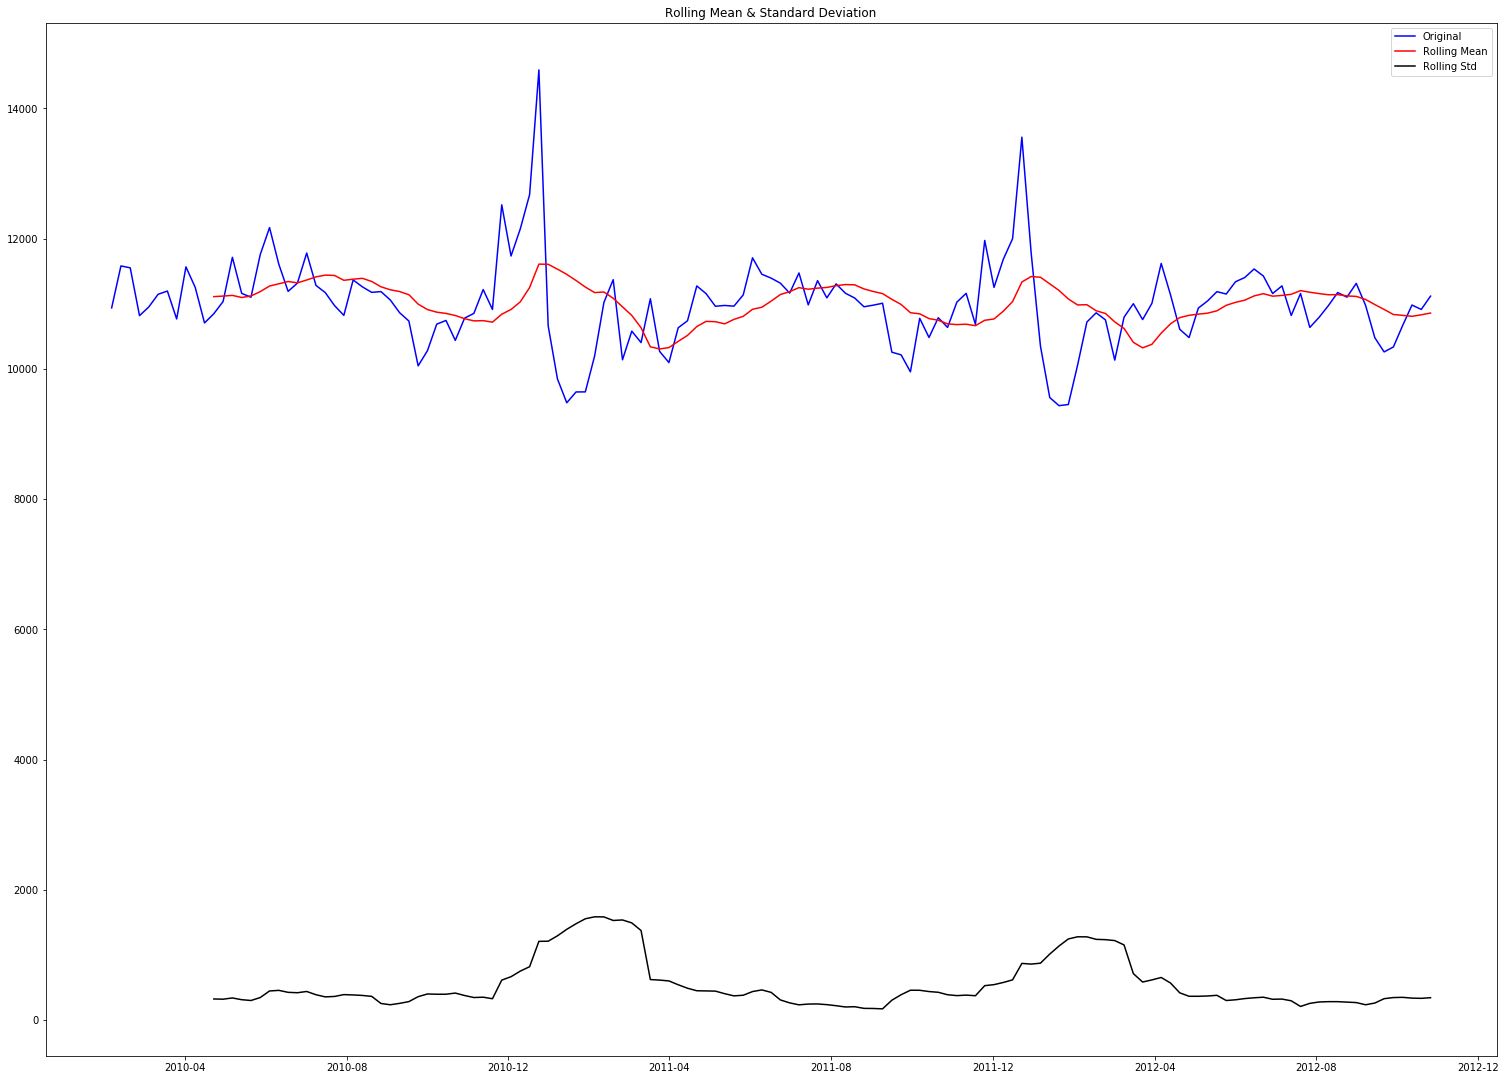

Results of Dickey-Fuller Test:
Test Statistic                -5.936737e+00
p-value                        2.311415e-07
#Lags Used                     4.000000e+00
Number of Observations Used    1.380000e+02
Critical Value (1%)           -3.478648e+00
Critical Value (5%)           -2.882722e+00
Critical Value (10%)          -2.578065e+00
dtype: float64


In [222]:
#ts=df["Weekly_Sales"]
df.sort_index(inplace=True)
ts=df["Weekly_Sales"].groupby(['Date']).mean()
ts.dropna()
test_stationarity(ts)
#print(ts)
#rolstd = ts.rolling(12).std()
#rolstd


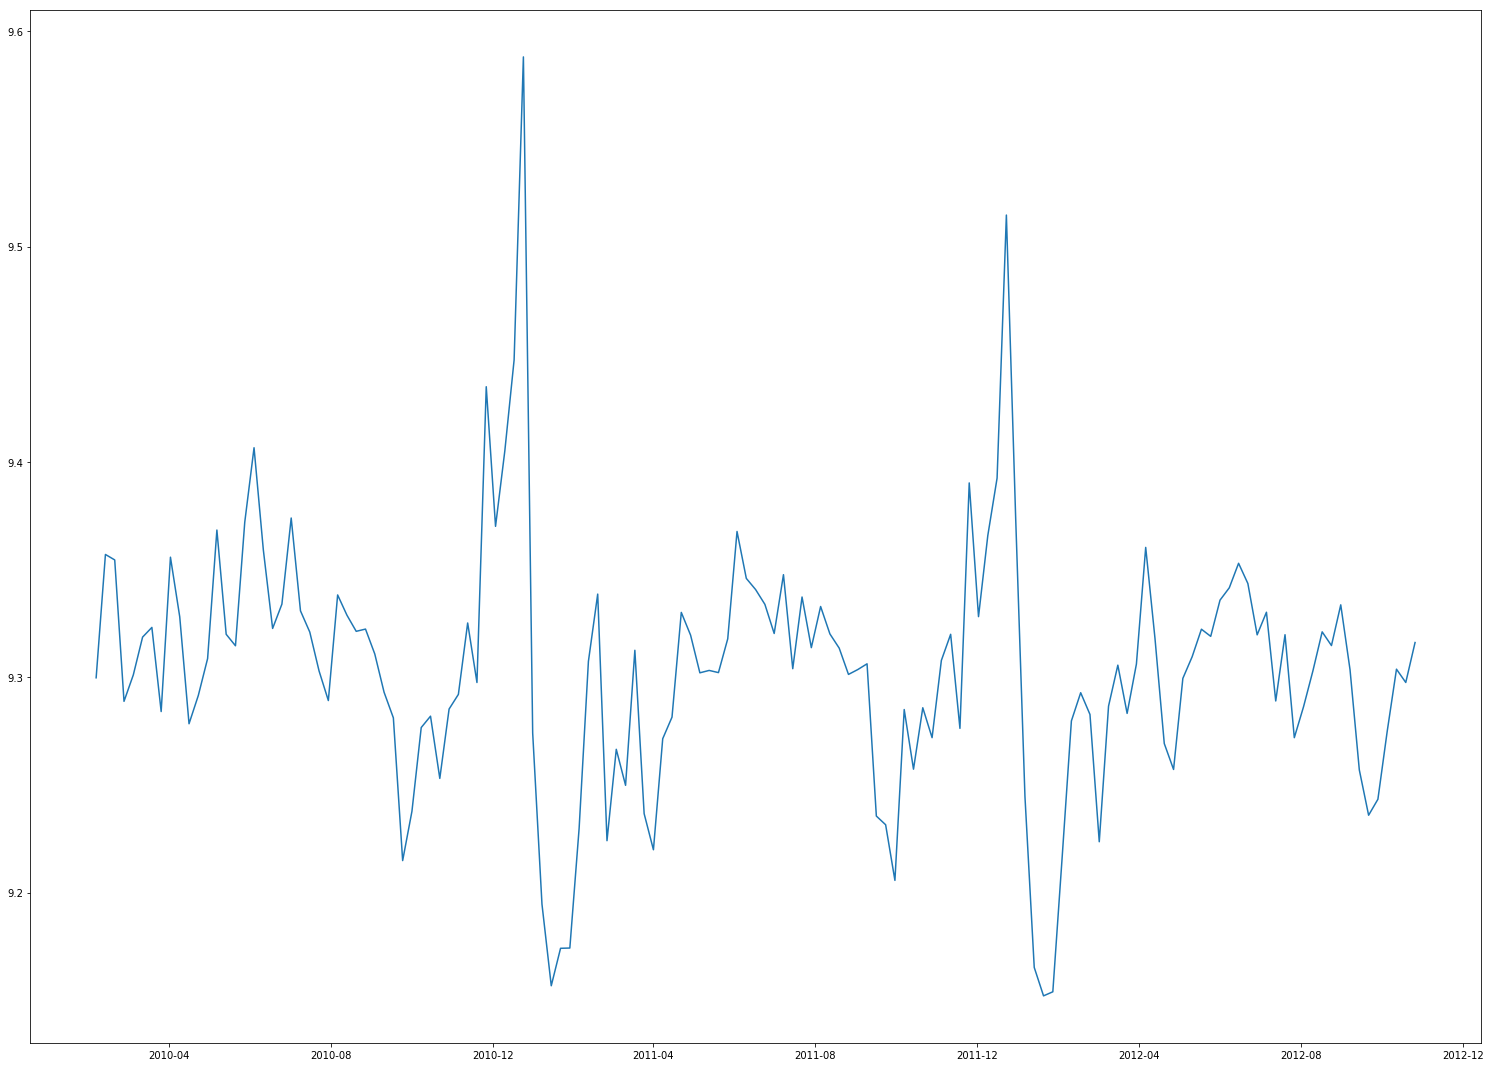

In [223]:
# as we see the p value < .05 Hense a/c to dickey fuller test, Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
# Test Statistic< critical value  hense the data is stationary.
# basic idea is to model the trend and seasonality in this series, so we can remove it and make the series stationary.
#Then we can go ahead and apply statistical forecasting to the stationary series
## std dev is quiet low and mean is not incraesing .. hense the data is stationary
#### Detrend
#reduce the trend using transformation.These transformation can be log, sq-rt, cube root etc .
ts_log=np.log(ts)
plt.plot(ts_log)

Date
2010-02-05        NaN
2010-02-12        NaN
2010-02-19        NaN
2010-02-26        NaN
2010-03-05        NaN
2010-03-12        NaN
2010-03-19        NaN
2010-03-26        NaN
2010-04-02        NaN
2010-04-09        NaN
2010-04-16        NaN
2010-04-23   -0.02352
Name: Weekly_Sales, dtype: float64

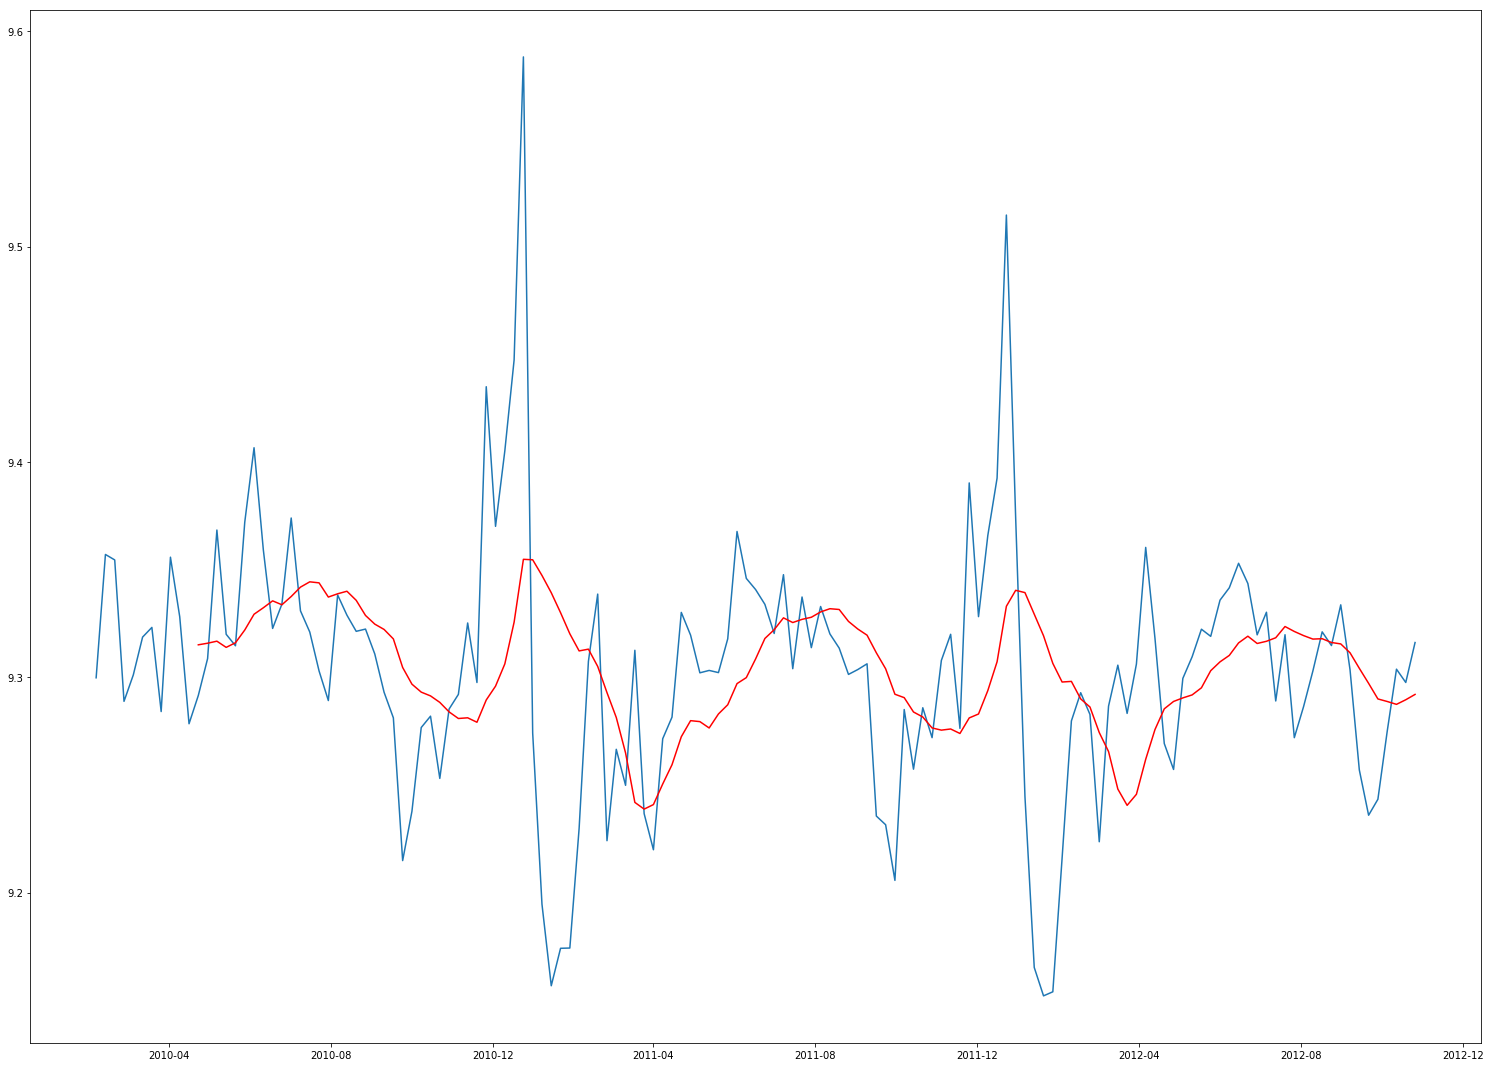

In [224]:
## much noise present , need to model the trend and remove from the series.
## Lets apply MA smoothning...
# timeseries.rolling(12).mean()
moving_avg=ts_log.rolling(12).mean()
plt.plot(ts_log)
plt.plot(moving_avg,color="red")

## Lets subtract rolling mean form the original series.. 
ts_log_moving_avg_diff=ts_log-moving_avg
ts_log_moving_avg_diff.head(12)

In [225]:
ts_log_moving_avg_diff.dropna(inplace=True)
ts_log_moving_avg_diff.head()

Date
2010-04-23   -0.023520
2010-04-30   -0.007142
2010-05-07    0.051615
2010-05-14    0.006077
2010-05-21   -0.001402
Name: Weekly_Sales, dtype: float64

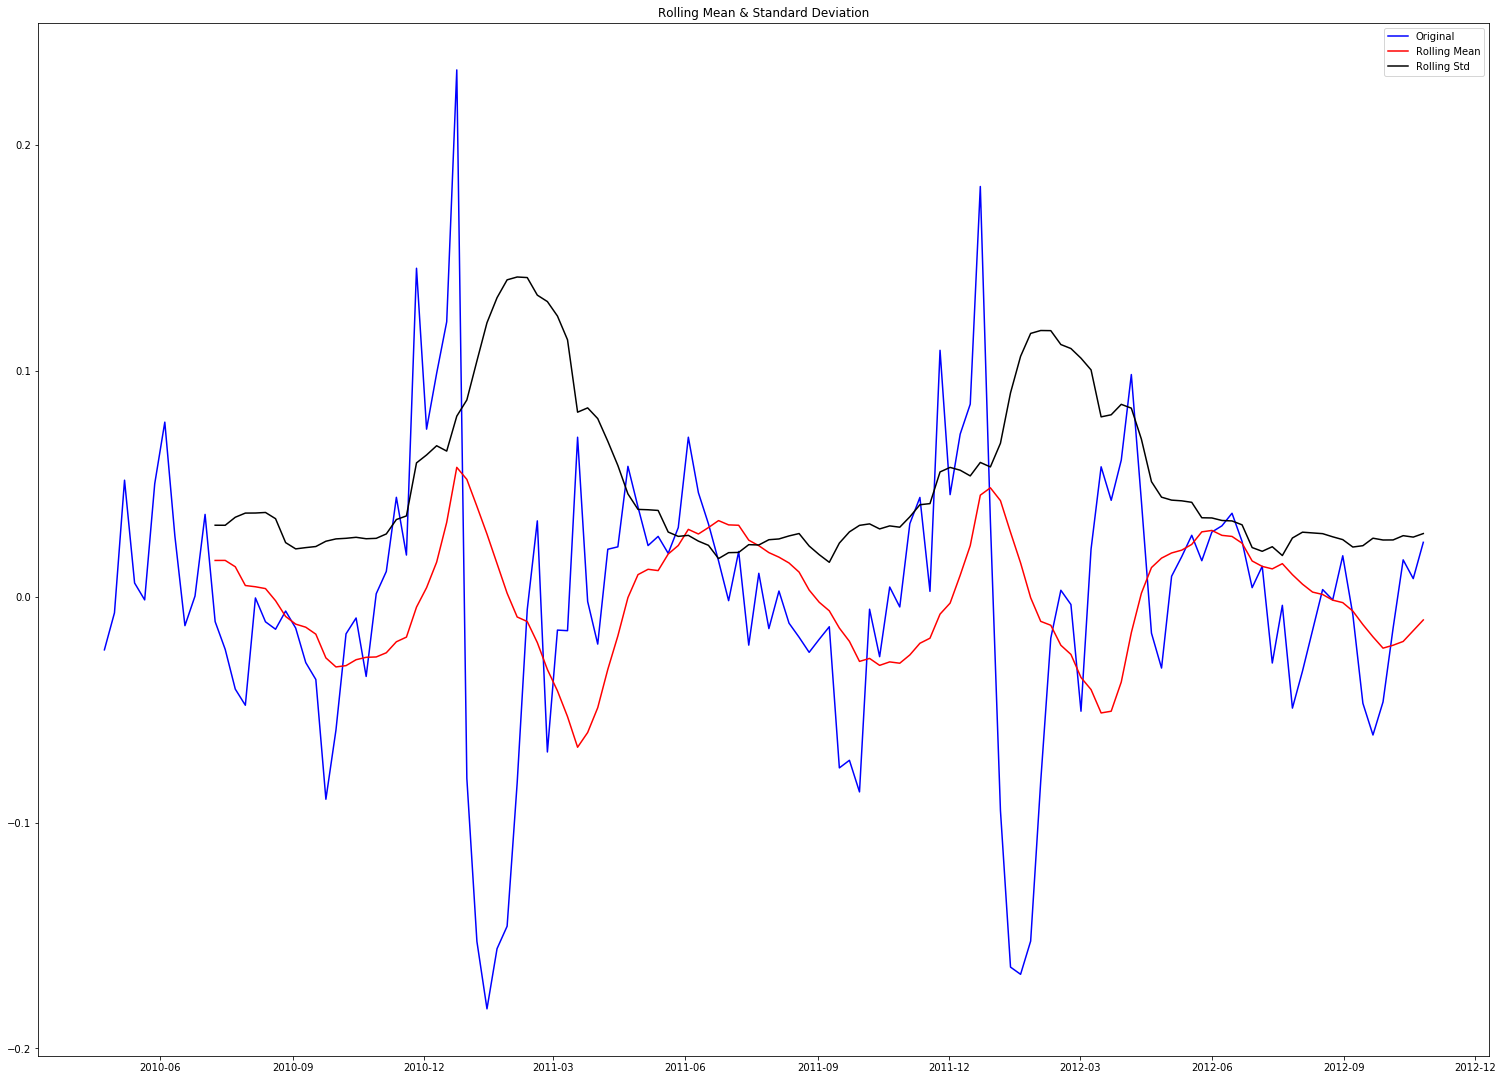

Results of Dickey-Fuller Test:
Test Statistic                  -5.318405
p-value                          0.000005
#Lags Used                       8.000000
Number of Observations Used    123.000000
Critical Value (1%)             -3.484667
Critical Value (5%)             -2.885340
Critical Value (10%)            -2.579463
dtype: float64


In [226]:
test_stationarity(ts_log_moving_avg_diff)

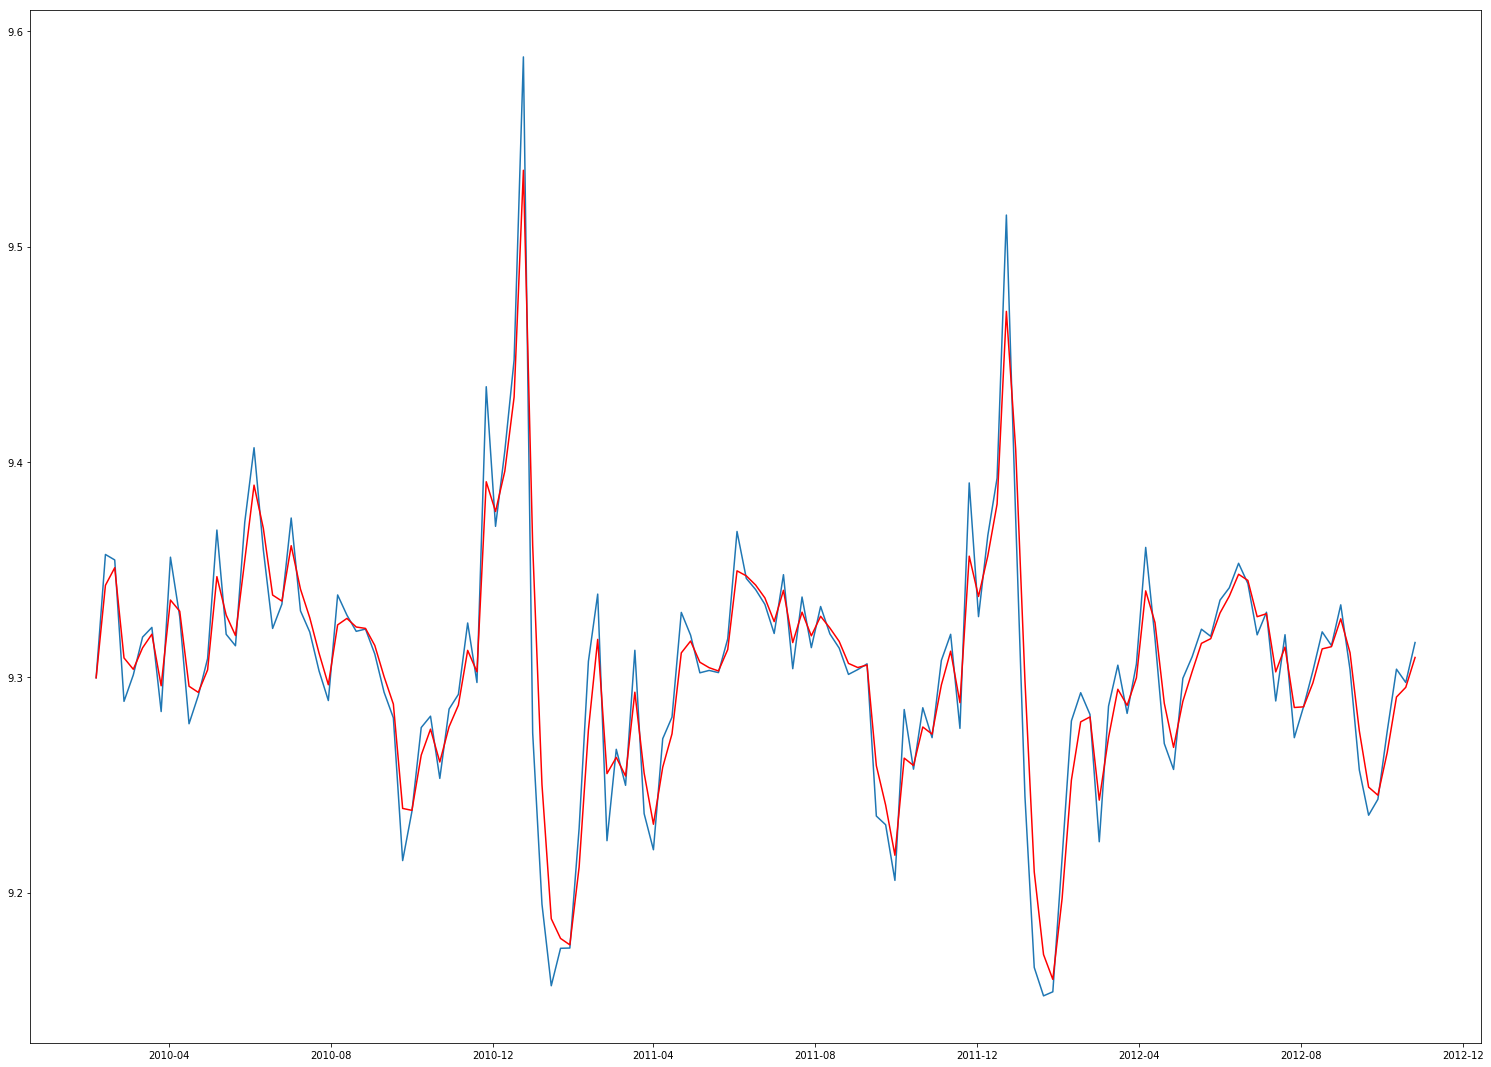

In [227]:
## lets use exponential smoothning..
#expwighted_avg=pd.DataFrame.ewm(ts_log,halflife=12)
#plt.plot(ts_log)
#expwighted_avg.values
#plt.plot(expwighted_avg,color='red')

expwighted_avg=ts_log.ewm(com=0.5).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg,color='red')

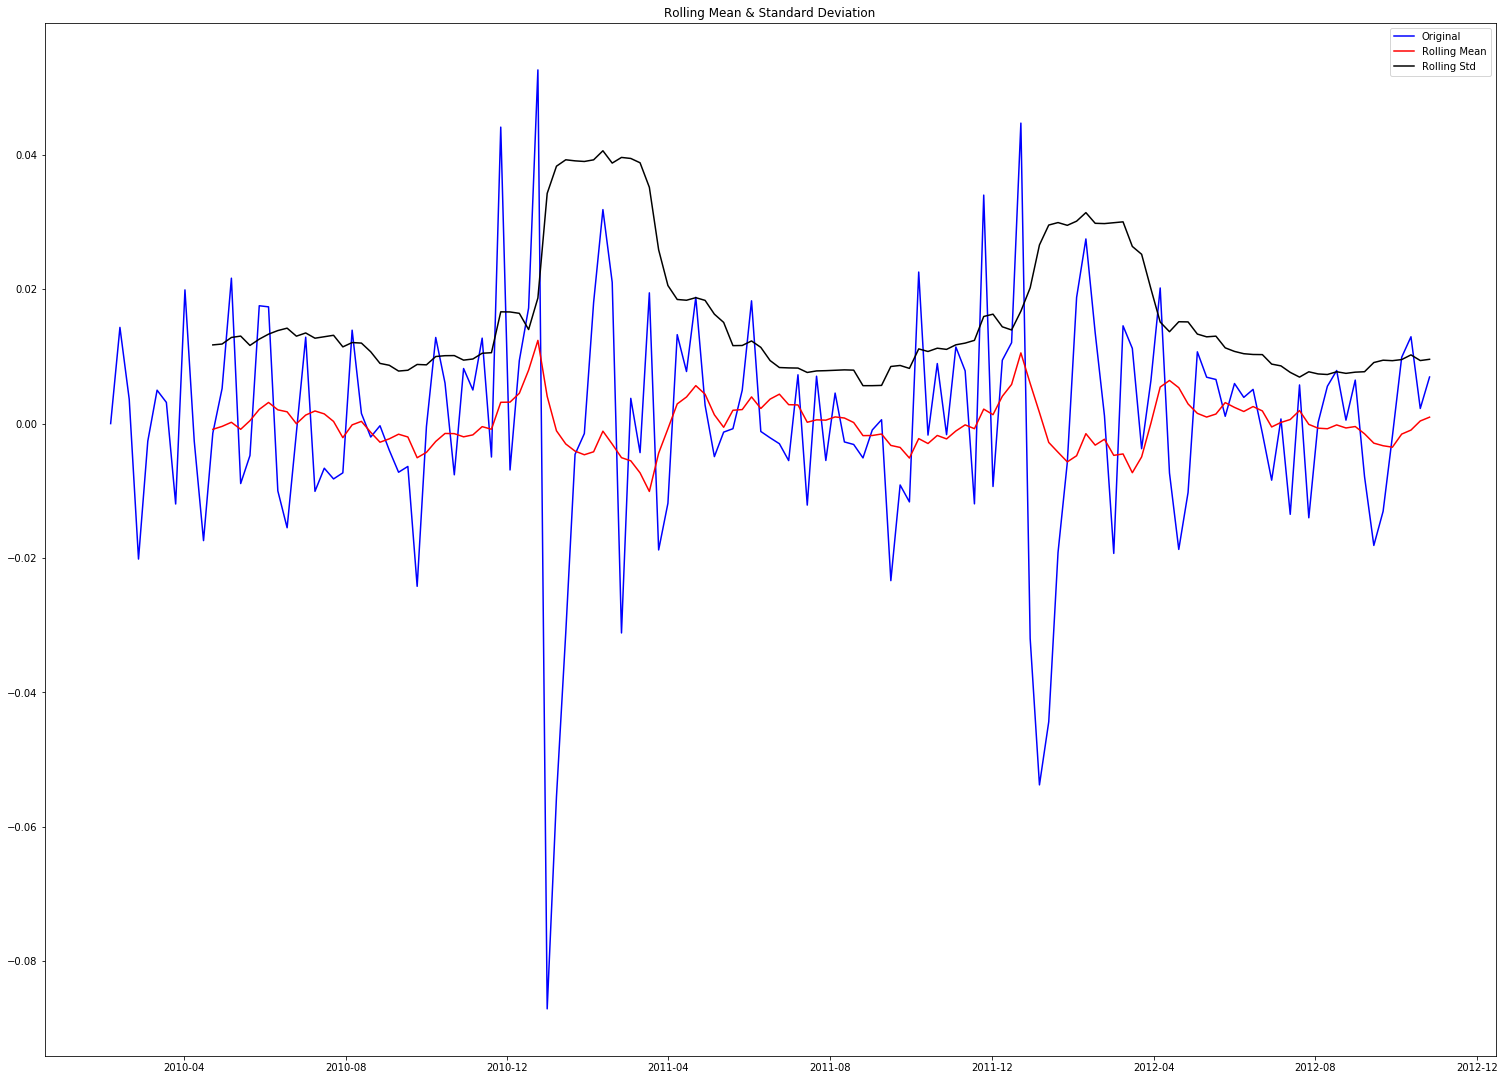

Results of Dickey-Fuller Test:
Test Statistic                -7.689839e+00
p-value                        1.428961e-11
#Lags Used                     4.000000e+00
Number of Observations Used    1.380000e+02
Critical Value (1%)           -3.478648e+00
Critical Value (5%)           -2.882722e+00
Critical Value (10%)          -2.578065e+00
dtype: float64


In [228]:
## Lets check the stationrity 
ts_log_ewma_diff=ts_log-expwighted_avg
test_stationarity(ts_log_ewma_diff)

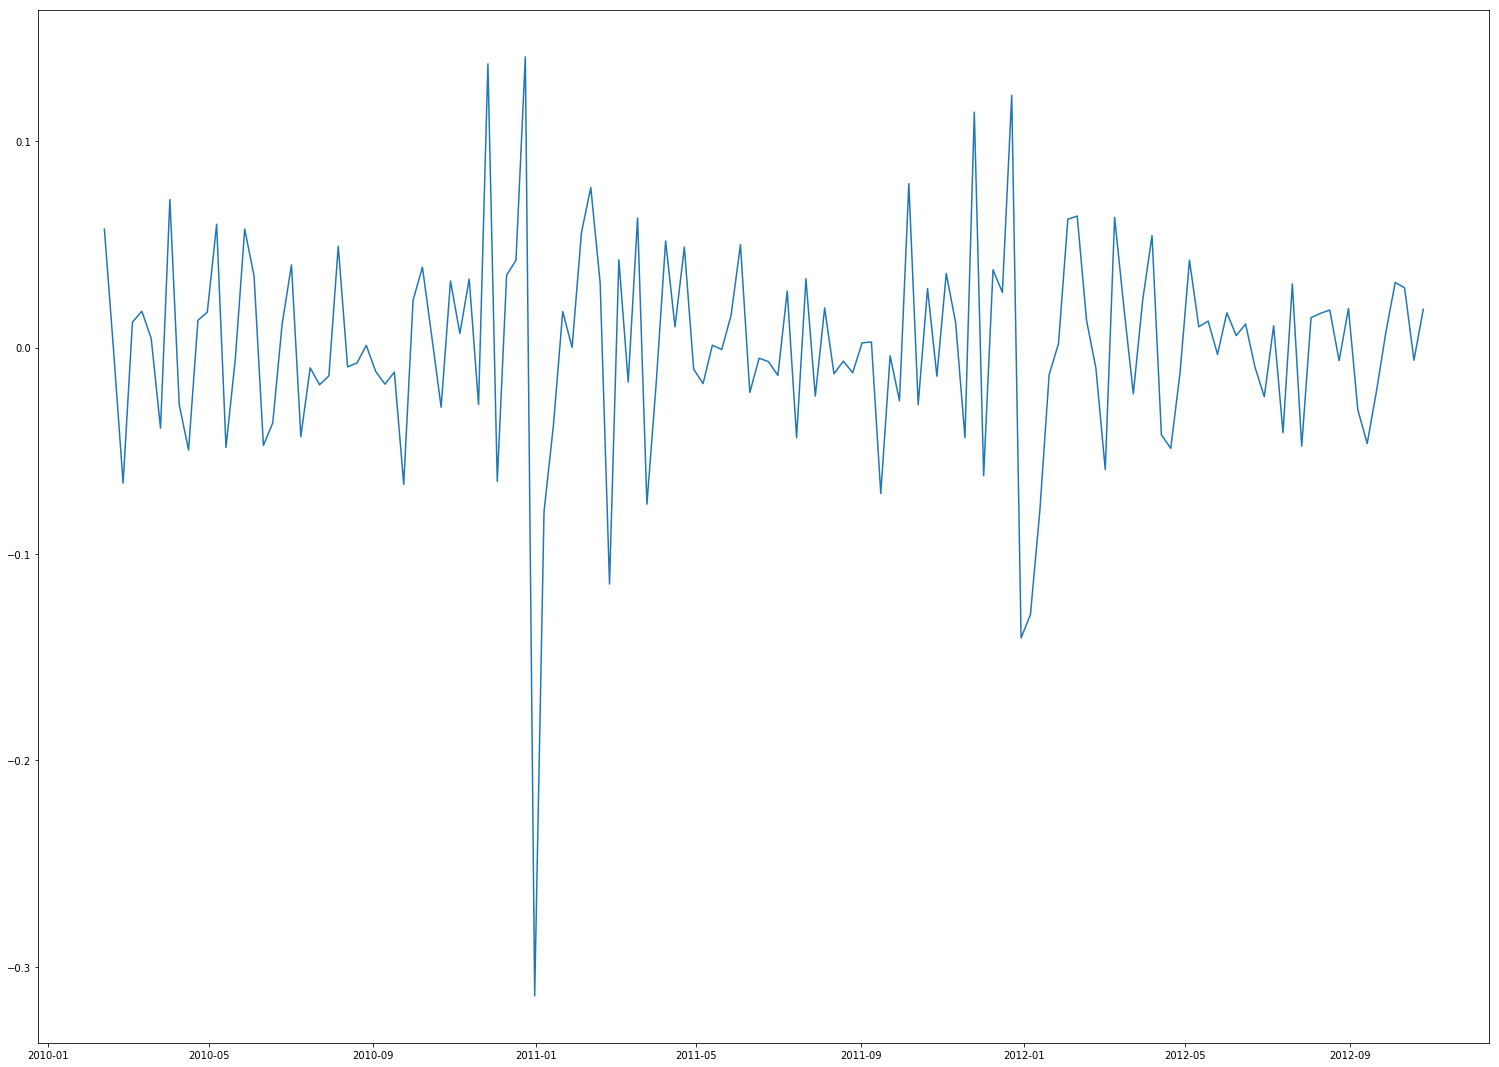

In [229]:
## Test Statistic  > Critical Value and p value< .05 .. stationary..
### Remove trend and seasonality both fpr timeseries..

# Differencing:
 #by taking difference using time lag

ts_log_diff=ts_log-ts_log.shift()
plt.plot(ts_log_diff)

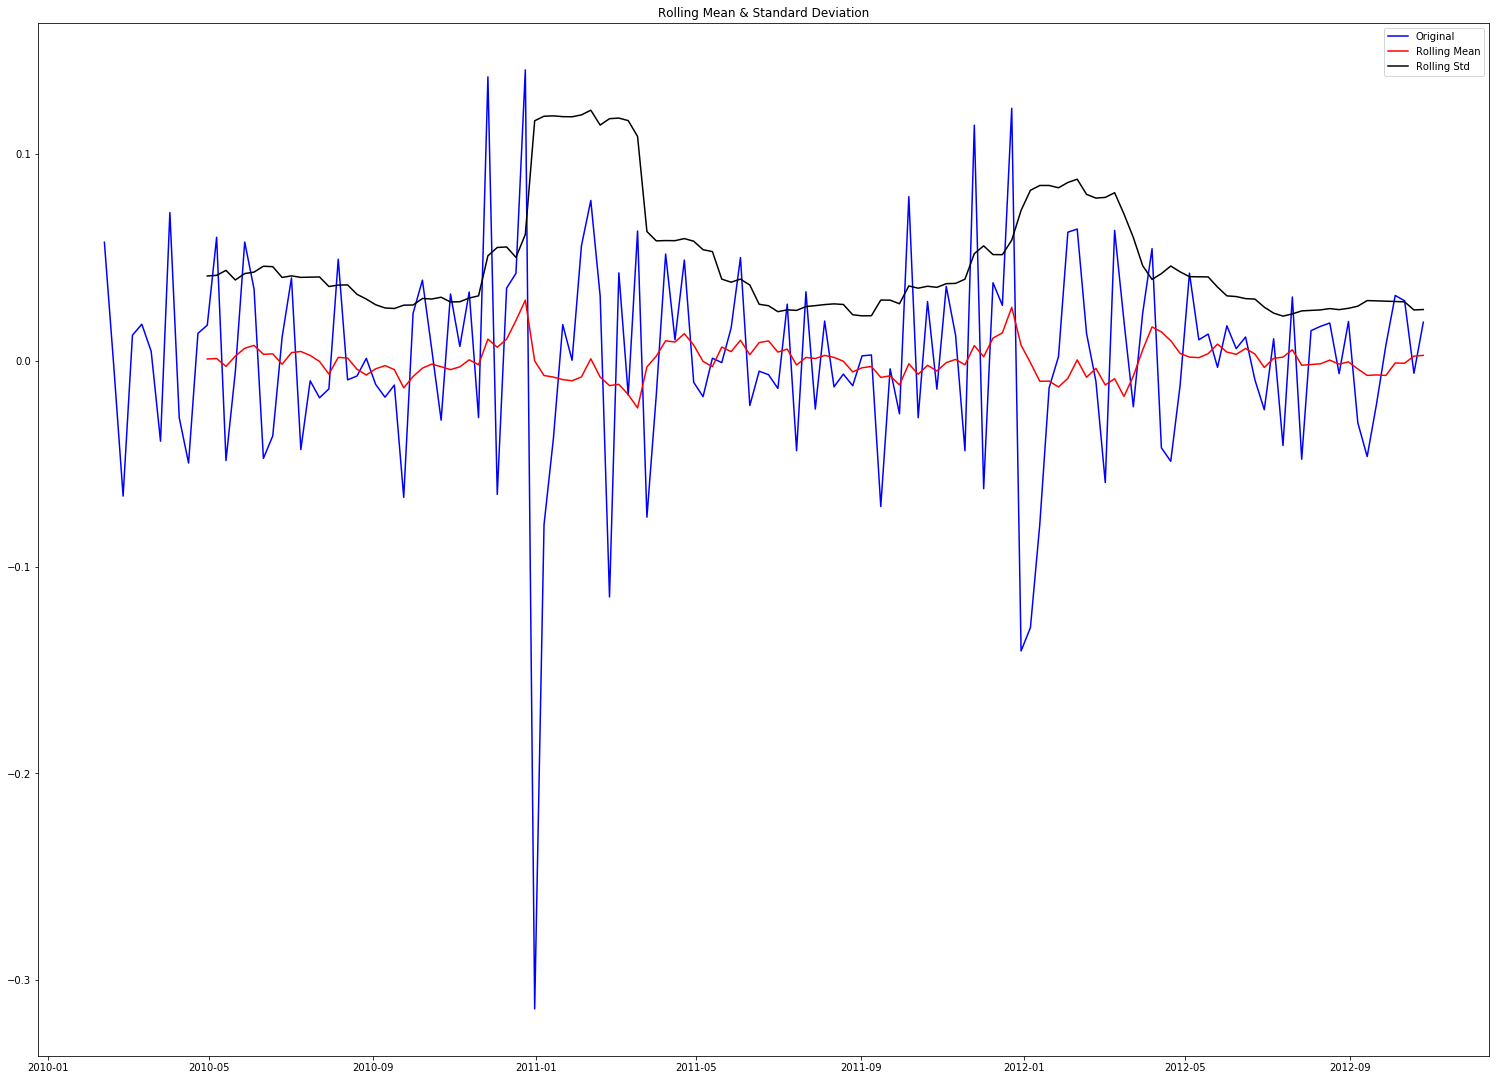

Results of Dickey-Fuller Test:
Test Statistic                -7.829552e+00
p-value                        6.346806e-12
#Lags Used                     5.000000e+00
Number of Observations Used    1.360000e+02
Critical Value (1%)           -3.479372e+00
Critical Value (5%)           -2.883037e+00
Critical Value (10%)          -2.578234e+00
dtype: float64


In [230]:
#ts_log_diff[~ts_log_diff.isin(['NaN', 'NaT']).any(axis=1)]
ts_log_diff.dropna(inplace= True)
#inplace= True
#ts_log_diff["2011-08-26"]
ts_log_diff.isnull()
test_stationarity(ts_log_diff)
## stationary because of below statistics

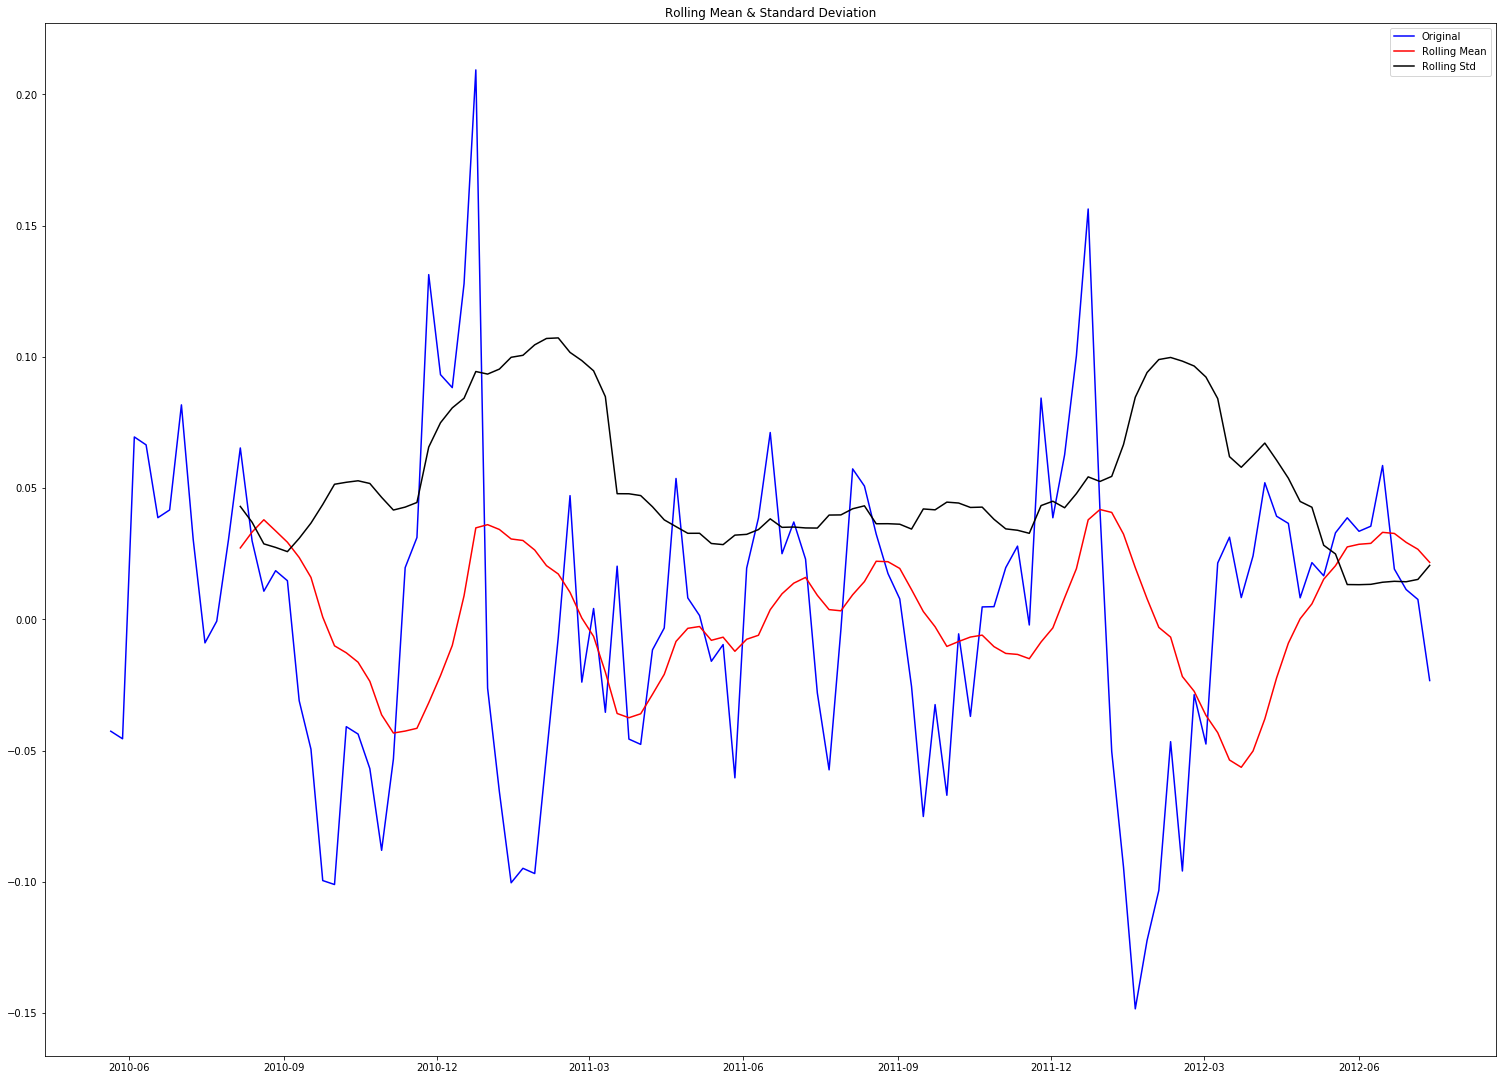

Results of Dickey-Fuller Test:
Test Statistic                  -5.464433
p-value                          0.000002
#Lags Used                       4.000000
Number of Observations Used    108.000000
Critical Value (1%)             -3.492401
Critical Value (5%)             -2.888697
Critical Value (10%)            -2.581255
dtype: float64


In [231]:
# Decomposing:
#Here we model both the trend and the seasonality, then the remaining part of the time series is returned
from statsmodels.tsa.seasonal import seasonal_decompose
ts_log.dropna(inplace=True)
decomposition=seasonal_decompose(ts_log,freq=30)

trend=decomposition.trend
seasonal=decomposition.seasonal
residual=decomposition.resid
ts_log_decompose=residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)  ## statioanry..

In [232]:
### Forcasting timeseries
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf,pacf
## acf and pacf plots

In [233]:
lag_Acf=acf(ts_log_diff,nlags=20)
lag_Pacf=pacf(ts_log_diff,nlags=20,method='ols')

Text(0.5,1,'Autocorelation Function')

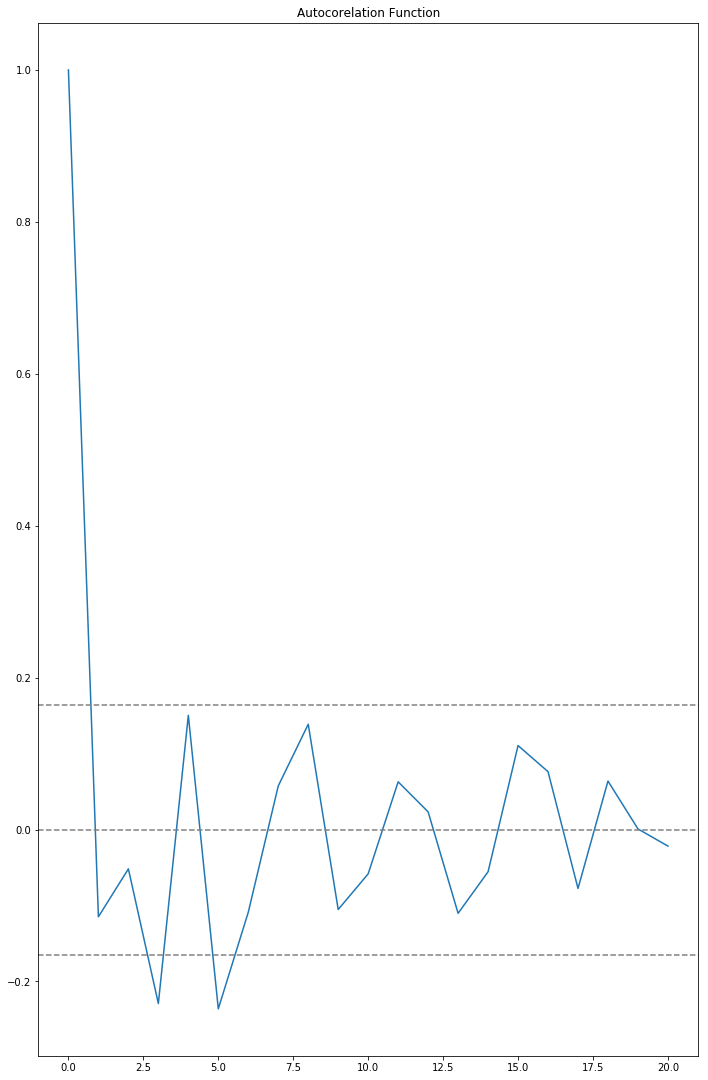

In [234]:
#Plot acf
plt.subplot(121)
plt.rcParams["figure.figsize"] = [26,19]
#plt.ylim(-.01, .1)
plt.plot(lag_Acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorelation Function')
##

# plt.figure(figsize=(3,4))   p value -> .6/.7

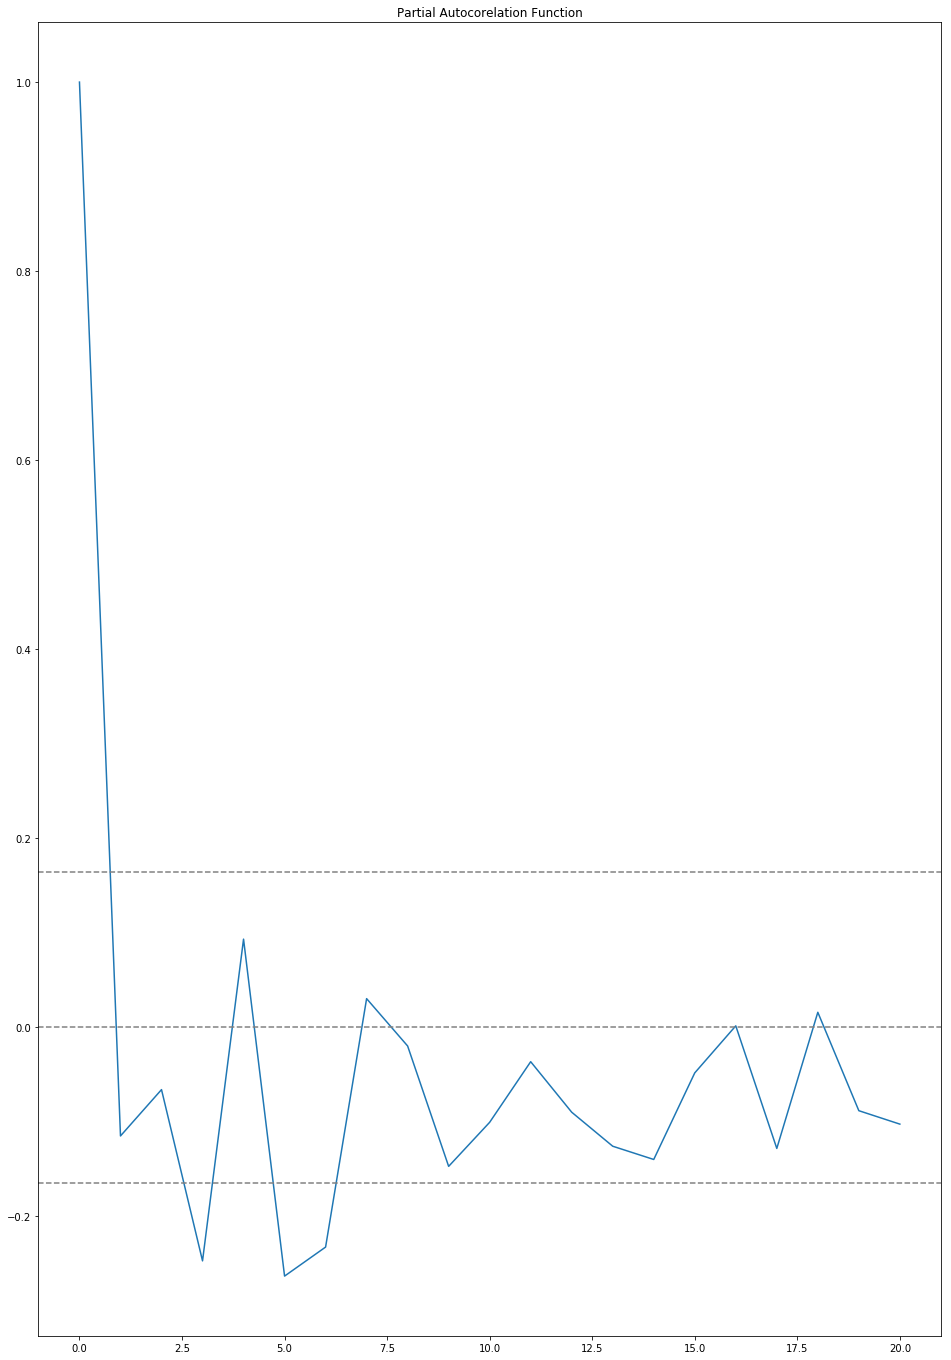

In [235]:
#plot PACF
#Plot acf
plt.subplot(122)
plt.rcParams["figure.figsize"] = [26,19]
#plt.ylim(-.04, .1)
plt.plot(lag_Pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorelation Function')
plt.tight_layout()
## look for value first time it touches upper confidence level..   ## .7/.8

C:\Users\sbha69\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)
C:\Users\sbha69\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)
C:\Users\sbha69\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\sbha69\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for mult

Text(0.5,1,'RSS: 0.3803')

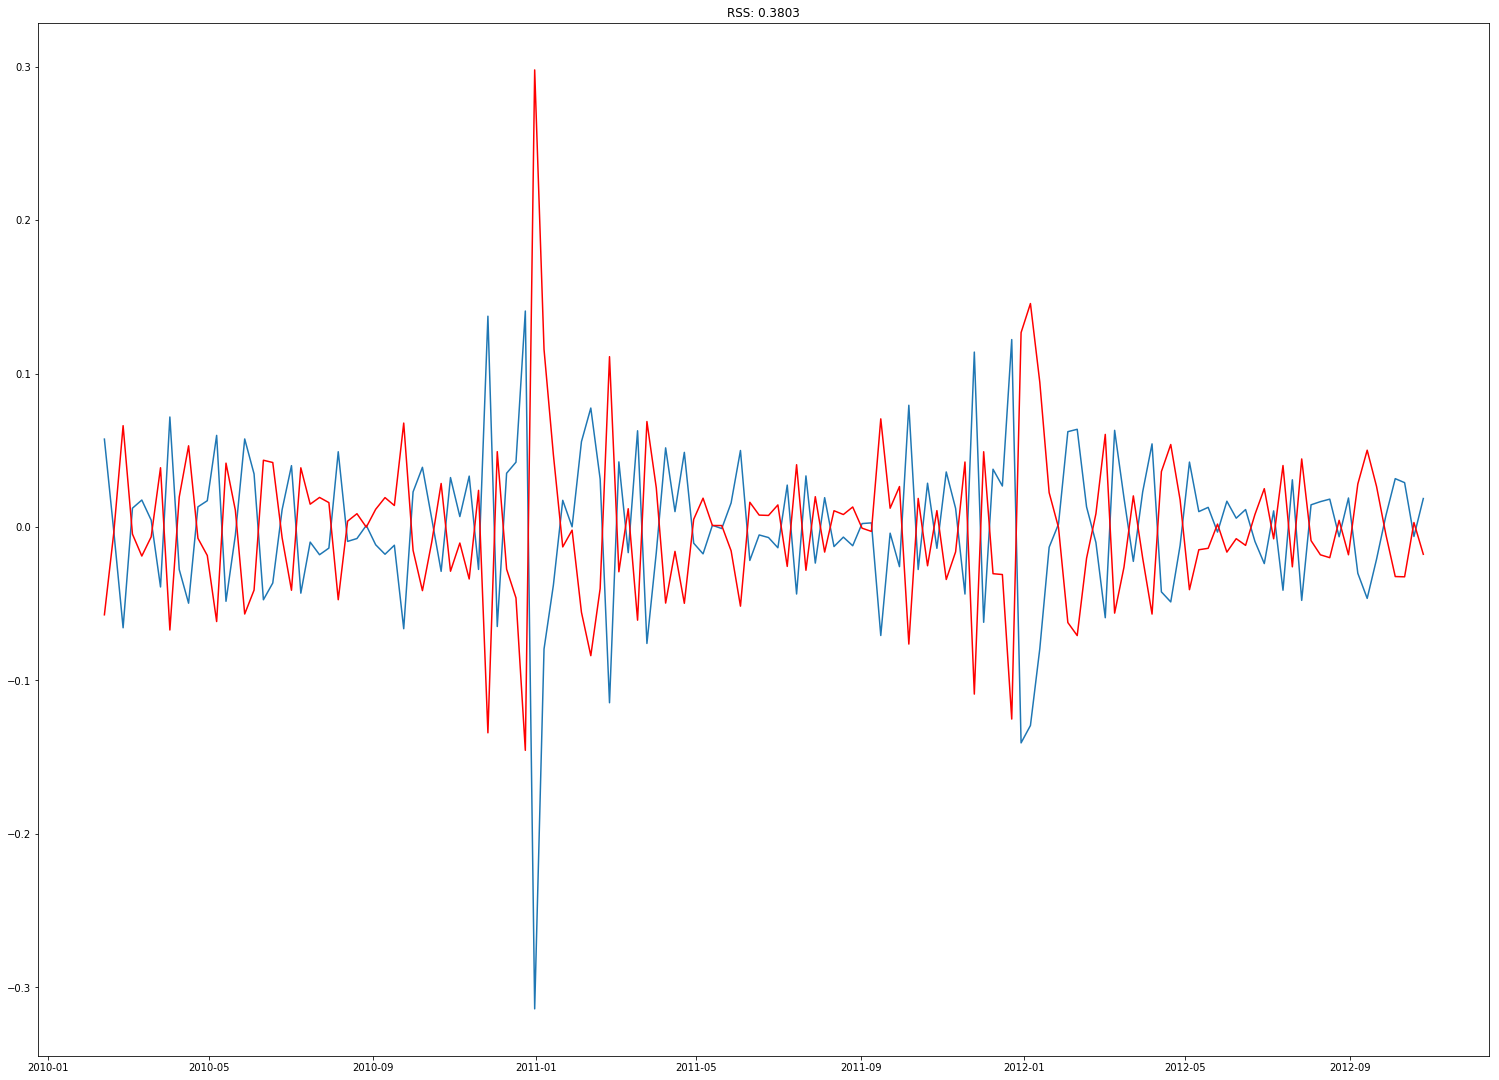

In [236]:
# AR Model..
Armodel=ARIMA(ts_log,order=(1,1,0))
result_AR=Armodel.fit(disp=-1)
plt.plot(ts_log_diff)
plt.plot(result_AR.fittedvalues-ts_log_diff,color='red')
plt.title('RSS: %.4f'%sum((result_AR.fittedvalues-ts_log_diff)**2))

C:\Users\sbha69\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)
C:\Users\sbha69\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)


Text(0.5,1,'RSS: 0.3791')

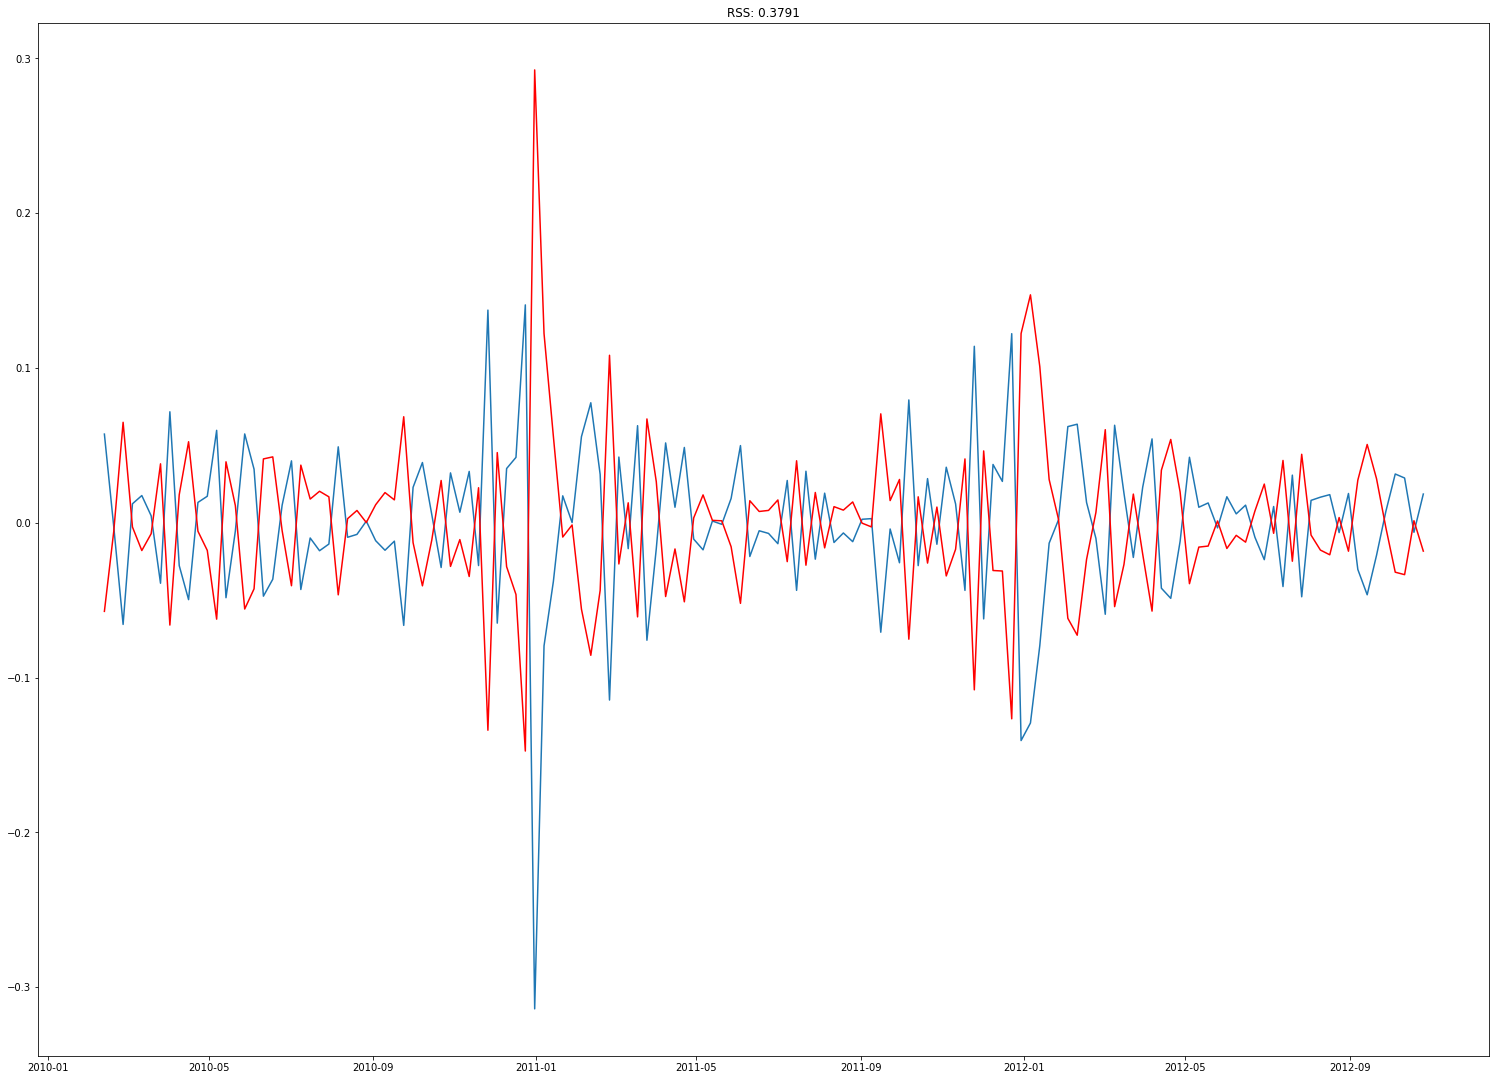

In [237]:
# MA Model
model=ARIMA(ts_log,order=(0,1,1))
result_MA=model.fit(disp=-1)
plt.plot(ts_log_diff)
plt.plot(result_MA.fittedvalues-ts_log_diff,color='red')
plt.title('RSS: %.4f'%sum((result_MA.fittedvalues-ts_log_diff)**2))

C:\Users\sbha69\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)
C:\Users\sbha69\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)


Text(0.5,1,'RSS: 0.3191')

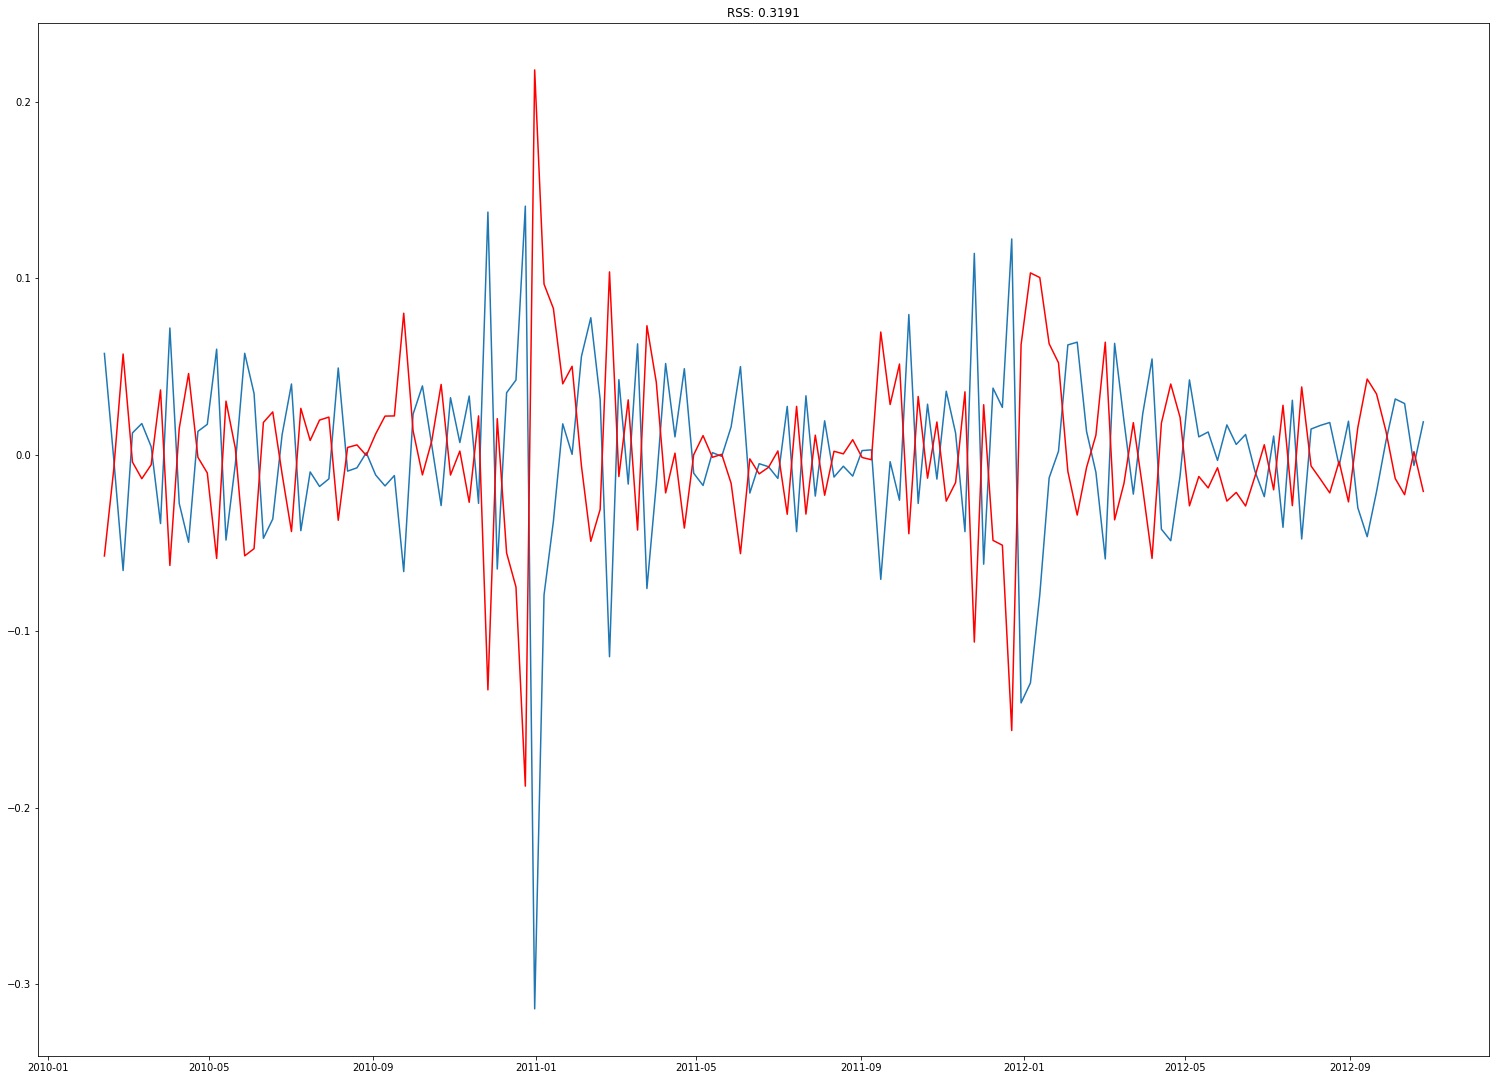

In [238]:
# MA Model
model=ARIMA(ts_log,order=(1,1,1))
result_ARIMA=model.fit(disp=-1)
plt.plot(ts_log_diff)
plt.plot(result_ARIMA.fittedvalues-ts_log_diff,color='red')
plt.title('RSS: %.4f'%sum((result_ARIMA.fittedvalues-ts_log_diff)**2))

In [241]:
##RSS for varios models..
#AR=.38
#MA=.37
#ARIMA=.31
## ARIMA has the best rss

### Bring back to scale..
predictions_ARIMA_diff=pd.Series(result_ARIMA.fittedvalues,copy=True)
print(predictions_ARIMA_diff.head())

Date
2010-02-12   -0.000169
2010-02-19   -0.010915
2010-02-26   -0.008708
2010-03-05    0.008042
2010-03-12    0.003897
dtype: float64


In [242]:
predictions_ARIMA_diff_cumsum=predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

Date
2010-02-12   -0.000169
2010-02-19   -0.011084
2010-02-26   -0.019793
2010-03-05   -0.011750
2010-03-12   -0.007853
dtype: float64


In [243]:
predictions_arima_log=pd.Series(ts_log.ix[0],index=ts_log.index)
#ts_log.ix[0]
#predictions_arima_log
predictions_arima_log=predictions_arima_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_arima_log.head()

C:\Users\sbha69\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


Date
2010-02-05    9.299810
2010-02-12    9.299641
2010-02-19    9.288726
2010-02-26    9.280018
2010-03-05    9.288060
dtype: float64

Text(0.5,1,'RSS: 1333.8778')

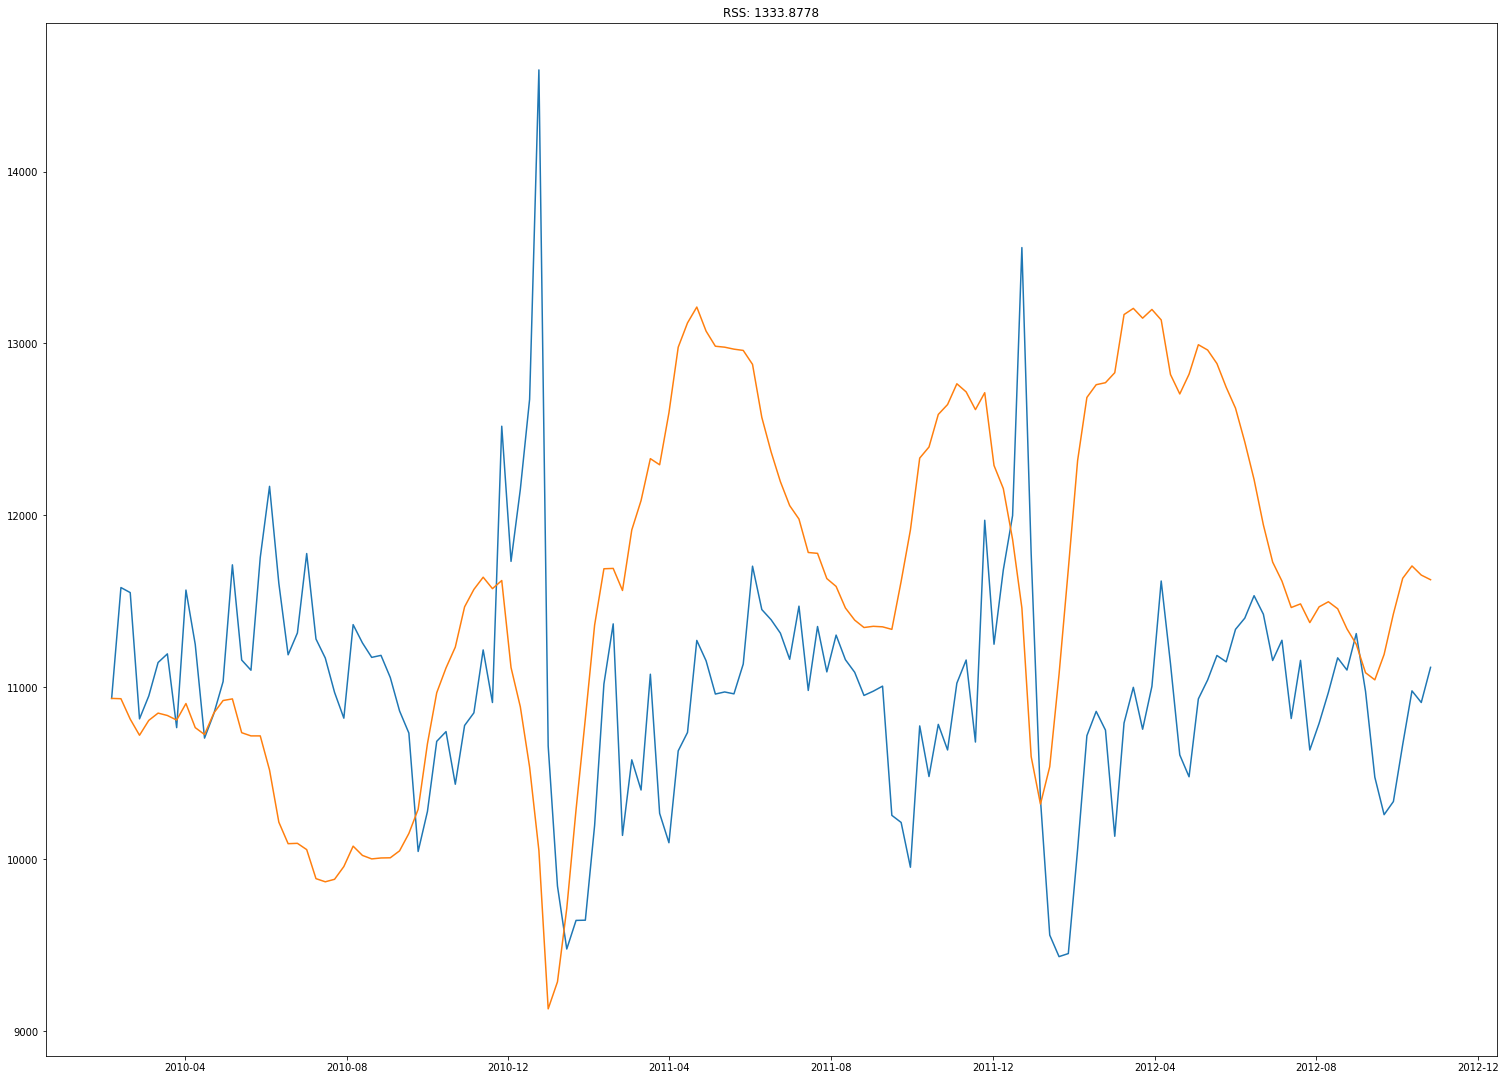

In [244]:
prediction_ARIMA=np.exp(predictions_arima_log)
plt.plot(ts)
plt.plot(prediction_ARIMA)
plt.title('RSS: %.4f'% np.sqrt(sum((prediction_ARIMA-ts)**2)/len(ts)))